In [12]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)

# DATA

In [13]:
# Define a transform to normalize the data (Preprocessing) and cast to tensor
   
train_transform = transforms.Compose([
                                    transforms.Resize((150,150)),
#                                     
                                    transforms.RandomRotation(20),
                                    transforms.RandomResizedCrop(size=124),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]) 
                                    ])
    
    
test_transform = transforms.Compose([
                                        transforms.Resize((150,150)),
                                        transforms.CenterCrop(124),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
        
                                    ])



root_dir = '../input/intel-image-classification/' 
# Load the training data
trainset = datasets.ImageFolder('C:\\Users\\ritth\\code\\Data\\Inlet data\\archive\\seg_train\\seg_train', transform = train_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle = True)


# Load the test data
testset = datasets.ImageFolder('C:\\Users\\ritth\\code\\Data\\Inlet data\\archive\\seg_test\\seg_test',transform=test_transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


print(trainloader.dataset, '\n')
print(testloader.dataset)

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: C:\Users\ritth\code\Data\Inlet data\archive\seg_train\seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(124, 124), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) 

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: C:\Users\ritth\code\Data\Inlet data\archive\seg_test\seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(124, 124))
               ToTensor()
               

In [14]:
images, labels = iter(trainloader).next()
print(f'image size: {images[0].shape}')
trainset.classes

image size: torch.Size([3, 124, 124])


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

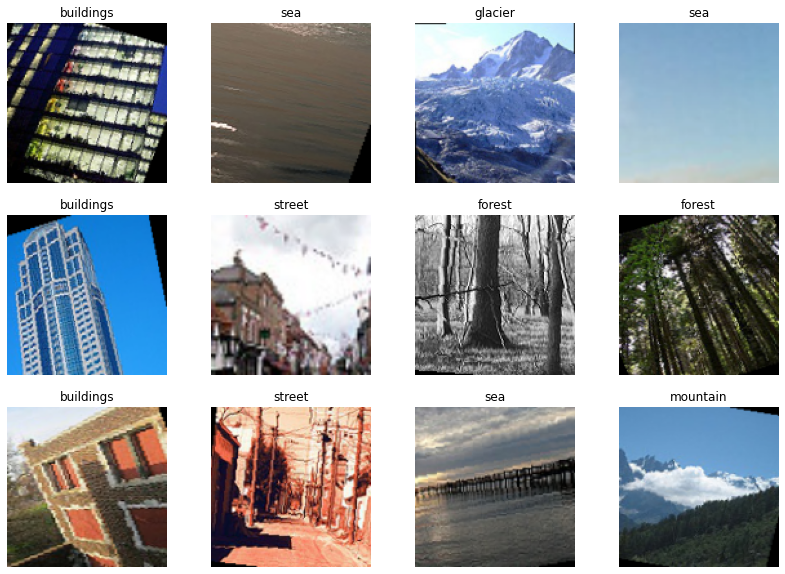

In [15]:
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    std=1/np.array([0.229, 0.224, 0.225])
)

def class_plot(data , classes ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        idx = np.random.randint(len(data))
        image,label = data[idx]
        label = int(label)
        l = classes[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(trainset,trainset.classes,inv_normalize);

# Model

In [16]:
model = models.resnext50_32x4d(pretrained = True)

# freezing paramaters
n_parameters = 0
for param in model.parameters():
    param.requires_grad = False

inputs = model.fc.in_features
outputs = len(trainset.classes)
# model.fc = nn.Linear(inputs, outputs)
clf = nn.Sequential(
              nn.Dropout(0.30), 
              nn.Linear(inputs, outputs)
                  )

model.fc = clf

In [17]:
inputs

2048

In [18]:
model.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=6, bias=True)
)

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [20]:
# Test
model(images[0].unsqueeze(0)).shape

torch.Size([1, 6])

# Training and validation

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [22]:
model.to(device)
learning_rate = 0.001
epochs = 30

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.90
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    # training
    for x_train_batch, y_train_batch in trainloader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        logits = model(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)

        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            x_test_batch = x_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)
            # logits
            test_logits = model(
                x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), './model.pth')
            model.to(device) # bring back to gpu

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./learning_curve.png', dpi = 200)

plt.show()

Epoch 1/30


KeyboardInterrupt: 

In [23]:
test_accuracies[-1]

IndexError: list index out of range